In [74]:
# 修改库后无需重启内核
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import TensorDataset, DataLoader
from mydataloader import MyDataLoader
from myconfig import MyConfig
from mymodel import SimpleMLP, WhatNet
import matplotlib.pyplot as plt

config = MyConfig()
data_path = config.data_path
results_path = config.results_path
train_ratio = config.train_ratio
label_pos = config.label_pos
batch_size = config.batch_size
num_epoch = config.num_epoch
lr = config.lr
device = config.device

data = MyDataLoader.load(data_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 对特征进行Z-score标准化

In [75]:
mu = data[:, label_pos+1:].mean(dim=0, keepdim=True)
sigma = data[:, label_pos+1:].std(dim=0, keepdim=True)
data[:, label_pos+1:] = (data[:, label_pos+1:] - mu) / sigma

### 划分数据集

In [76]:
num_train = int(data.shape[0] * train_ratio)
num_valid = len(data) - num_train

# 直接搬运到device
train_X = data[:num_train, label_pos+1:].to(device)
train_y = data[:num_train, label_pos].reshape(-1, 1).to(device)
valid_X = data[num_train:, label_pos+1:].to(device)
valid_y = data[num_train:, label_pos].reshape(-1, 1).to(device)

train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

### 训练

In [77]:
net = WhatNet()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
net.to(device) # 搬模型可原地，搬数据需要赋值
train_hist, valid_hist = [], []

for epoch in range(num_epoch):
    net.train()
    loss_train = 0
    for X, y in train_loader:
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item() * len(y)

    net.eval()
    with torch.no_grad():
        y_hat_valid = net(valid_X)
        loss_valid = loss_fn(y_hat_valid, valid_y).item()

    loss_train /= num_train
    train_hist.append(loss_train)
    valid_hist.append(loss_valid)
    print(f"epoch: {epoch+1}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}")

epoch: 1, loss_train: 0.40055, loss_valid: 0.39607
epoch: 2, loss_train: 0.39834, loss_valid: 0.39389
epoch: 3, loss_train: 0.39615, loss_valid: 0.39173
epoch: 4, loss_train: 0.39398, loss_valid: 0.38958
epoch: 5, loss_train: 0.39182, loss_valid: 0.38745
epoch: 6, loss_train: 0.38968, loss_valid: 0.38533
epoch: 7, loss_train: 0.38755, loss_valid: 0.38323
epoch: 8, loss_train: 0.38545, loss_valid: 0.38115
epoch: 9, loss_train: 0.38336, loss_valid: 0.37909
epoch: 10, loss_train: 0.38128, loss_valid: 0.37704
epoch: 11, loss_train: 0.37922, loss_valid: 0.37500
epoch: 12, loss_train: 0.37718, loss_valid: 0.37298
epoch: 13, loss_train: 0.37515, loss_valid: 0.37098
epoch: 14, loss_train: 0.37314, loss_valid: 0.36899
epoch: 15, loss_train: 0.37114, loss_valid: 0.36702
epoch: 16, loss_train: 0.36916, loss_valid: 0.36506
epoch: 17, loss_train: 0.36719, loss_valid: 0.36312
epoch: 18, loss_train: 0.36524, loss_valid: 0.36120
epoch: 19, loss_train: 0.36330, loss_valid: 0.35928
epoch: 20, loss_train

### 用MSE和R**2评估结果

In [78]:
def cal_r2(y_mse, y_true):
    """
    根据MSE和真值计算决定系数R**2
    """
    y_true = y_true.reshape(-1)
    y_var = y_true.var().item()
    return 1 - (y_mse / y_var)

valid_mse = valid_hist[-1]
with torch.no_grad():
    y_hat_train = net(train_X)
    train_mse = loss_fn(y_hat_train, train_y).item()

valid_r2 = cal_r2(valid_mse, valid_y)
train_r2 = cal_r2(train_mse, train_y)
print(f"train_mse: {train_mse:.5f}, train_r2: {train_r2:.5f}")
print(f"valid_mse: {valid_mse:.5f}, valid_r2: {valid_r2:.5f}")

train_mse: 0.04997, train_r2: 0.69807
valid_mse: 0.05038, valid_r2: 0.69585


### 绘制loss曲线

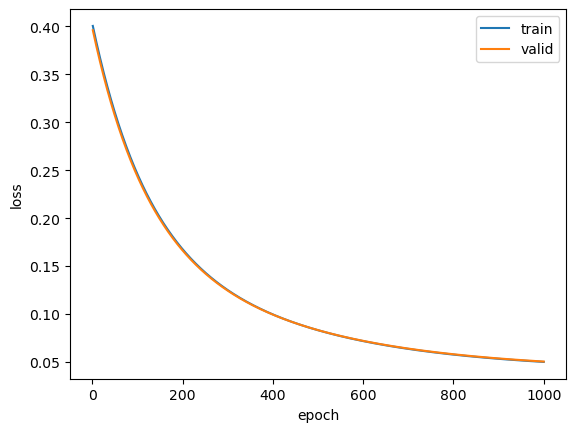

In [79]:
epochs = [epoch + 1 for epoch in range(num_epoch)]

plt.figure()
plt.plot(epochs, train_hist, label="train")
plt.plot(epochs, valid_hist, label="valid")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### pred-true图

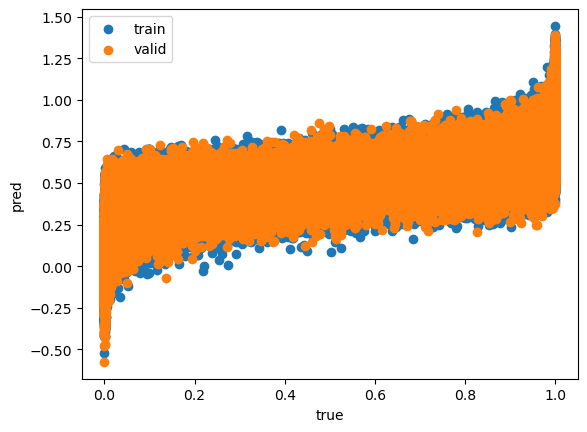

In [80]:
plt.figure()
plt.scatter(train_y.to("cpu"), y_hat_train.to("cpu"), label="train")
plt.scatter(valid_y.to("cpu"), y_hat_valid.to("cpu"), label="valid")
plt.xlabel("true")
plt.ylabel("pred")
plt.legend()
plt.show()

### 保存结果

In [81]:
torch.save(net.state_dict(), results_path + "\\net.params")
torch.save(mu, results_path + "\\mu.txt")
torch.save(sigma, results_path + "\\sigma.txt")